In [1]:
import pandas as pd
import numpy as np

df = pd.read_excel('../data/meta_ads_cleaned.xlsx', engine='openpyxl')

df.head()

engagement_df = df[df['Result indicator'] == 'actions:post_engagement'].copy()
engagement_df.reset_index(drop=True, inplace=True)

In [2]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

engagement_df_encoded = pd.get_dummies(engagement_df, columns=categorical_cols, drop_first=True)


In [3]:
engagement_df_encoded['Starts'] = pd.to_datetime(engagement_df_encoded['Starts'])

engagement_df_encoded['day'] = engagement_df_encoded['Starts'].dt.day
engagement_df_encoded['month'] = engagement_df_encoded['Starts'].dt.month
engagement_df_encoded['weekday'] = engagement_df_encoded['Starts'].dt.weekday


In [4]:
import numpy as np

engagement_df_encoded['log_spend'] = np.log1p(engagement_df_encoded['Amount spent'])
engagement_df_encoded['log_reach'] = np.log1p(engagement_df_encoded['Reach'])
engagement_df_encoded['log_impressions'] = np.log1p(engagement_df_encoded['Impressions'])
engagement_df_encoded['log_post_eng'] = np.log1p(engagement_df_encoded['Post engagements'])
engagement_df_encoded['log_comments'] = np.log1p(engagement_df_encoded['Post comments'])
engagement_df_encoded['log_reactions'] = np.log1p(engagement_df_encoded['Post reactions'])
engagement_df_encoded['log_saves'] = np.log1p(engagement_df_encoded['Post saves'])
engagement_df_encoded['log_shares'] = np.log1p(engagement_df_encoded['Post shares'])
engagement_df_encoded['log_cost_per_eng'] = np.log1p(engagement_df_encoded['Cost per post engagement (USD)'])


In [5]:
# Target variable
target_col = 'log_post_eng'

# Choose predictors based on correlation analysis
base_features = [
    'log_spend', 'log_reactions', 'log_saves', 'log_shares', 'log_comments'
]

# Time features
time_features = ['day', 'month', 'weekday']

# One-hot encoded categorical columns
encoded_features = [col for col in engagement_df_encoded.columns if any(p in col for p in ['Platforme_', 'Placement_', 'Device_', 'Ad set budget type_'])]

# Final feature list
selected_features = base_features + time_features + encoded_features

# Create modeling DataFrame
engagement_model_df = engagement_df_encoded[[target_col] + selected_features].dropna()

# Split X and y
X_engagement = engagement_model_df.drop(target_col, axis=1)
y_engagement = engagement_model_df[target_col]


## Feature Engineering – Engagement Campaigns

We prepared the dataset for modeling `log_post_eng` using:
- One-hot encoding of platform, placement, device, and budget type
- Log-transformation of key engagement metrics
- Extraction of time features: day, month, weekday

### Selected Features:
- `log_spend`, `log_reactions`, `log_saves`, `log_shares`, `log_comments`
- Categorical encodings
- Time-based indicators

✅ Dataset is now ready for model training.


In [6]:
from sklearn.model_selection import train_test_split

X_eng_train, X_eng_test, y_eng_train, y_eng_test = train_test_split(
    X_engagement, y_engagement, test_size=0.2, random_state=42
)


In [7]:
from sklearn.linear_model import LinearRegression

lr_eng = LinearRegression()
lr_eng.fit(X_eng_train, y_eng_train)


LinearRegression()

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_eng_pred = lr_eng.predict(X_eng_test)

rmse_eng = np.sqrt(mean_squared_error(y_eng_test, y_eng_pred))
r2_eng = r2_score(y_eng_test, y_eng_pred)

print(f"RMSE: {rmse_eng:.4f}")
print(f"R² Score: {r2_eng:.4f}")


RMSE: 0.9279
R² Score: 0.5829


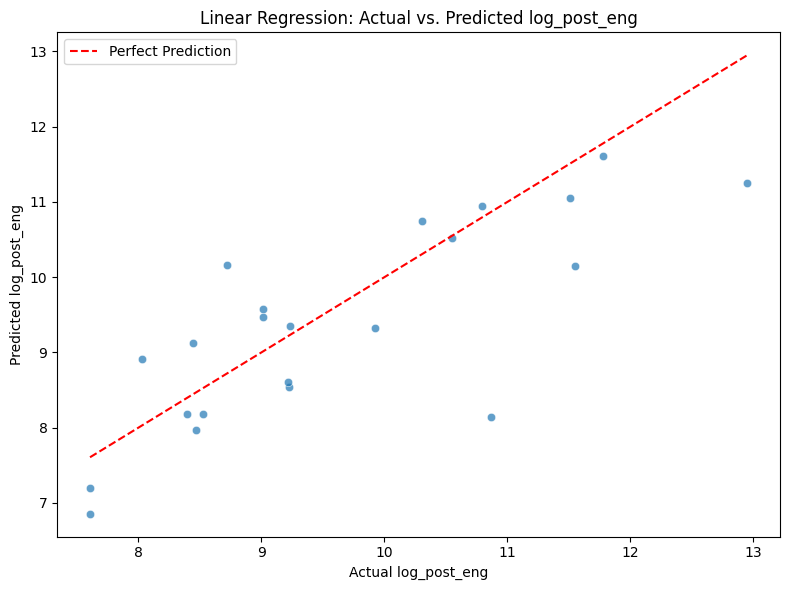

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_eng_test, y=y_eng_pred, alpha=0.7)
plt.plot([y_eng_test.min(), y_eng_test.max()], [y_eng_test.min(), y_eng_test.max()], '--r', label='Perfect Prediction')
plt.xlabel("Actual log_post_eng")
plt.ylabel("Predicted log_post_eng")
plt.title("Linear Regression: Actual vs. Predicted log_post_eng")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-3, 3, 100)

ridge_eng = RidgeCV(alphas=alphas, scoring='neg_root_mean_squared_error', cv=5)
ridge_eng.fit(X_eng_train, y_eng_train)

ridge_preds = ridge_eng.predict(X_eng_test)
ridge_rmse = np.sqrt(mean_squared_error(y_eng_test, ridge_preds))
ridge_r2 = r2_score(y_eng_test, ridge_preds)

print(f"Best alpha: {ridge_eng.alpha_}")
print(f"Ridge RMSE: {ridge_rmse:.4f}")
print(f"Ridge R²: {ridge_r2:.4f}")


Best alpha: 5.72236765935022
Ridge RMSE: 0.9476
Ridge R²: 0.5649


In [11]:
from sklearn.ensemble import RandomForestRegressor

rf_eng = RandomForestRegressor(n_estimators=100, random_state=42)
rf_eng.fit(X_eng_train, y_eng_train)

rf_preds = rf_eng.predict(X_eng_test)
rf_rmse = np.sqrt(mean_squared_error(y_eng_test, rf_preds))
rf_r2 = r2_score(y_eng_test, rf_preds)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R²: {rf_r2:.4f}")


Random Forest RMSE: 0.8450
Random Forest R²: 0.6541


In [12]:
from xgboost import XGBRegressor

xgb_eng = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_eng.fit(X_eng_train, y_eng_train)

xgb_preds = xgb_eng.predict(X_eng_test)
xgb_rmse = np.sqrt(mean_squared_error(y_eng_test, xgb_preds))
xgb_r2 = r2_score(y_eng_test, xgb_preds)

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R²: {xgb_r2:.4f}")


XGBoost RMSE: 0.8203
XGBoost R²: 0.6740


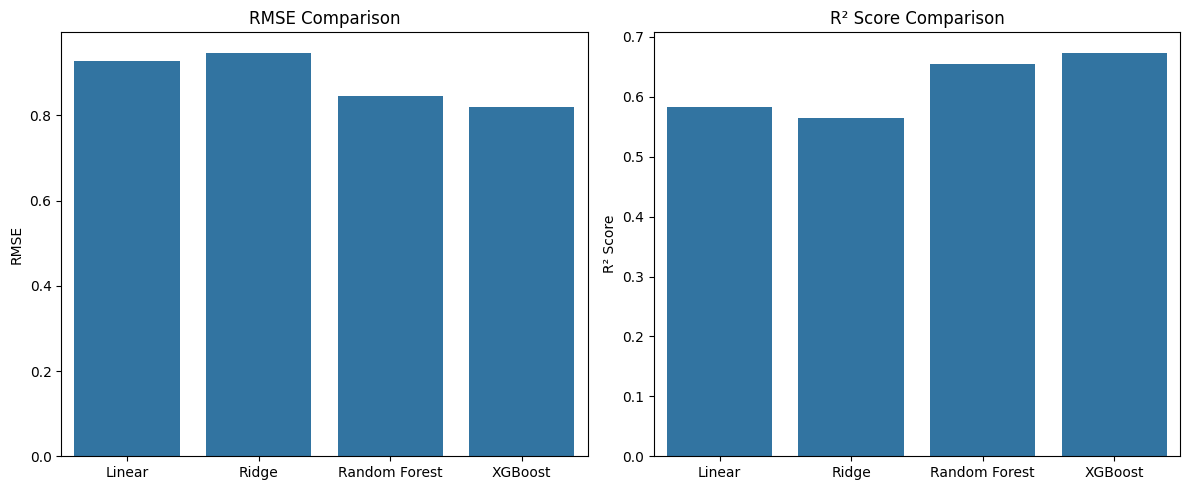

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Linear', 'Ridge', 'Random Forest', 'XGBoost']
rmse_vals = [rmse_eng, ridge_rmse, rf_rmse, xgb_rmse]
r2_vals = [r2_eng, ridge_r2, rf_r2, xgb_r2]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=models, y=rmse_vals)
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=r2_vals)
plt.title("R² Score Comparison")
plt.ylabel("R² Score")

plt.tight_layout()
plt.show()


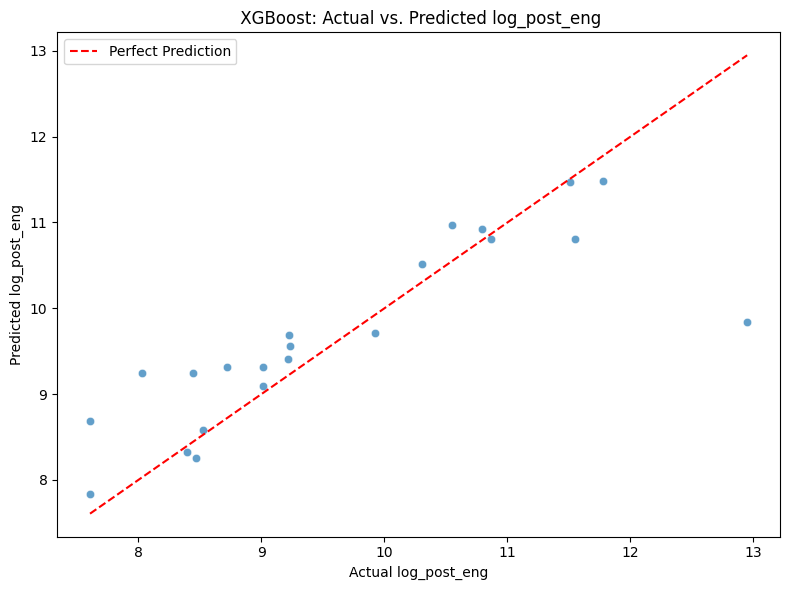

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Actual vs. Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_eng_test, y=xgb_preds, alpha=0.7)
plt.plot([y_eng_test.min(), y_eng_test.max()], [y_eng_test.min(), y_eng_test.max()], '--r', label='Perfect Prediction')
plt.xlabel("Actual log_post_eng")
plt.ylabel("Predicted log_post_eng")
plt.title(" XGBoost: Actual vs. Predicted log_post_eng")
plt.legend()
plt.tight_layout()
plt.show()


##  Final Model Benchmark – Engagement Campaigns

We modeled log-transformed post engagements (`log_post_eng`) using multiple regression models. The dataset included spend, reactions, shares, saves, comments, and encoded categorical variables.

###  Evaluation Results:

| Model           | RMSE   | R² Score |
|------------------|--------|----------|
| Linear Regression| 0.9279 | 0.5829   |
| Ridge Regression | 0.9476 | 0.5649   |
| Random Forest    | 0.8450 | 0.6541   |
| **XGBoost**      | **0.8203** | **0.6740** |

###  Selected Model: XGBoost
- Chosen for its best balance of accuracy and generalization.
- RMSE: `0.8203` log units (approx. ±2.27x error in actual engagements)
- R²: `0.6740` — explains ~67% of the variance in engagement volume.

###  Model Fit Visualization

A scatterplot of actual vs. predicted values confirms the model's ability to approximate `log_post_eng`, with most predictions aligning near the diagonal.

✅ This model is suitable for forecasting and analyzing future campaign performance.


In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


In [17]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_eng_train, y_eng_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [18]:
best_xgb = grid_search_xgb.best_estimator_

# Predict
best_preds = best_xgb.predict(X_eng_test)

# Evaluate
best_rmse = np.sqrt(mean_squared_error(y_eng_test, best_preds))
best_r2 = r2_score(y_eng_test, best_preds)

print("Best Parameters:", grid_search_xgb.best_params_)
print(f"Tuned XGBoost RMSE: {best_rmse:.4f}")
print(f"Tuned XGBoost R² Score: {best_r2:.4f}")


Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Tuned XGBoost RMSE: 0.8101
Tuned XGBoost R² Score: 0.6821


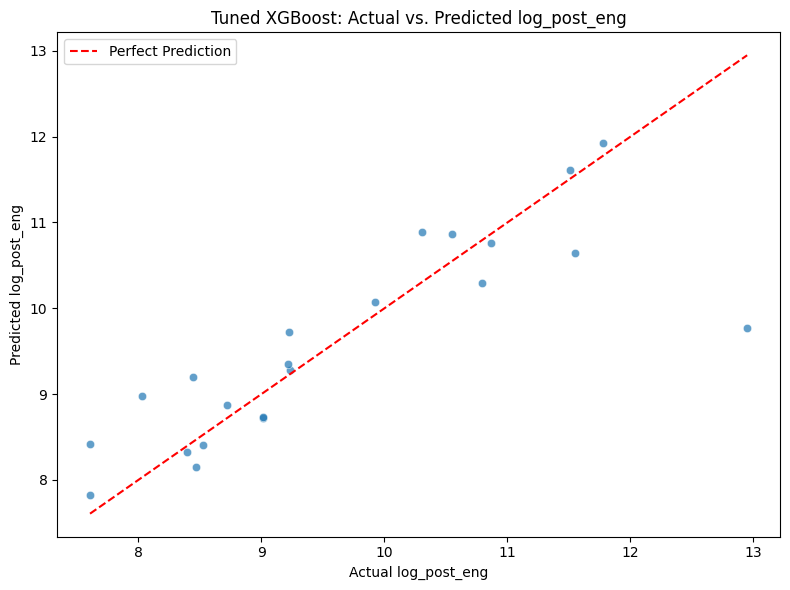

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use predictions from tuned XGBoost model
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_eng_test, y=best_preds, alpha=0.7)
plt.plot([y_eng_test.min(), y_eng_test.max()], [y_eng_test.min(), y_eng_test.max()], '--r', label='Perfect Prediction')

plt.xlabel("Actual log_post_eng")
plt.ylabel("Predicted log_post_eng")
plt.title("Tuned XGBoost: Actual vs. Predicted log_post_eng")
plt.legend()
plt.tight_layout()
plt.show()


## GridSearchCV – XGBoost Tuning (Engagement Campaigns)

We applied `GridSearchCV` to optimize XGBoost hyperparameters with 5-fold cross-validation.

### Best Parameters:
- `n_estimators`: 200
- `max_depth`: 3
- `learning_rate`: 0.2
- `subsample`: 0.8
- `colsample_bytree`: 1

### Final Performance:
| Model              | RMSE   | R² Score |
|---------------------|--------|----------|
| Baseline XGBoost    | 0.8203 | 0.6740   |
| **Tuned XGBoost**   | **0.8101** | **0.6821** |

✅ The tuned model will replace the baseline version for predicting `log_post_eng` in engagement campaigns.


In [23]:
import joblib

# Save your best performing model
joblib.dump(best_xgb, 'C:/Users/ghass/orange-tunisie-branding-analytics/models/xgb_post_engagement_model.joblib')

['C:/Users/ghass/orange-tunisie-branding-analytics/models/xgb_post_engagement_model.joblib']

## Model Persistence – Tuned XGBoost (Engagement Campaigns)

We saved the tuned XGBoost model (`best_xgb`) for predicting `log_post_eng` using `joblib`.

- File: `C:/Users/ghass/orange-tunisie-branding-analytics/models/xgb_post_engagement_model.joblib`
- Easily reloadable for future predictions or deployment

The model will be used in reporting, forecasting, and potential dashboard integrations.
